In [1]:
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
import pandas as pd
import matplotlib.patches as mpatches
%matplotlib inline



# Global Parameters

In [2]:
# mycolor
pytorch    = '#136aa8'
tensorflow = '#ff7527'
mycolors = [pytorch, tensorflow]

# working dirs
datadir = "../results/tf_fp32_amp_fw"
ptdir   = "/global/homes/y/yswang/mlperf-deepcam/analysis"

# Load Data

In [3]:
selectkeys = ['Name', 'Invocations', 'CUDA Time', 'Performance GFlop/s', 'FLOPs', 'DRAM AI', 'DRAM Bytes']

tfcombineddf = pd.read_csv(os.path.join(datadir,"combined_profile.csv"))
ptcombineddf = pd.read_csv(os.path.join(ptdir,"combined.csv"))
tfprofiledf  = pd.read_csv(os.path.join(datadir,"full_profile.csv"))
ptprofiledf  = pd.read_csv(os.path.join(ptdir,"profile.csv"))

# PyTorch vs. Tensorflow (FW pass only)

## Overview
* Total number of FLOPs are similar
* PT has 2.2x more data movement
* PT is 3x slower

In [4]:
tfdf = tfcombineddf[selectkeys]

ptcombineddf['Name'] = 'PyTorch'
ptdf = ptcombineddf.loc[ptcombineddf['Pass'].str.contains("forward"), selectkeys].copy()

combineddf = ptdf.append(tfdf)

display(combineddf)

,Name,Invocations,CUDA Time,Performance GFlop/s,FLOPs,DRAM AI,DRAM Bytes
1,PyTorch,4782,0.615992,17808.638230,1.096998e+13,90.478692,1.212438e+11
0,TensorFlow,654,0.213214,48661.342288,1.037529e+13,190.721624,5.440019e+10


## Detailed comparison

In [5]:
ptdf = ptprofiledf.loc[ptprofiledf['Pass'].str.contains("forward"), selectkeys].sort_values('CUDA Time', ascending=False).reset_index(drop=True).copy()
#profiledf = profiledf.sort_values('CUDA Time', ascending=False).reset_index(drop=True)
tfdf = tfprofiledf[selectkeys].copy()

# print
#display(ptdf)
#display(tfdf)

### Top 5 kernels

In [6]:
topN = 5

# get top5 kernels
top_tfdf = tfdf.head(topN).copy()
top_ptdf = ptdf.head(topN).copy()

# insert total runtime
tf_runtime = tfdf['CUDA Time'].sum()
pt_runtime = ptdf['CUDA Time'].sum()
top_tfdf['Total Time'] = tf_runtime
top_ptdf['Total Time'] = pt_runtime
# insert total FLOPs
tf_flops = tfdf['FLOPs'].sum()
pt_flops = ptdf['FLOPs'].sum()
top_tfdf['Total FLOPs'] = tf_flops
top_ptdf['Total FLOPs'] = pt_flops
# insert total bytes
tf_bytes = tfdf['DRAM Bytes'].sum()
pt_bytes = ptdf['DRAM Bytes'].sum()
top_tfdf['Total Bytes'] = tf_bytes
top_ptdf['Total Bytes'] = pt_bytes
# insert total invocations
tf_calls = tfdf['Invocations'].sum()
pt_calls = ptdf['Invocations'].sum()
top_tfdf['Total Invocations'] = tf_calls
top_ptdf['Total Invocations'] = pt_calls

top_tfdf['Name'] = 'Tensorflow'
top_ptdf['Name'] = 'PyTorch'

# merge
topdf = top_tfdf.append(top_ptdf)
topdf = topdf.groupby(['Name', 'Total Time', 'Total FLOPs', 'Total Bytes', 'Total Invocations']).sum().reset_index()

# recalculate AI and FLOP rates
topdf['Performance GFlop/s'] = topdf['FLOPs'] / topdf['CUDA Time'] /1e9
topdf['DRAM AI'] = topdf['FLOPs'] / topdf['DRAM Bytes']
topdf['% of overall runtime'] = topdf['CUDA Time'] / topdf['Total Time']*100
topdf['% of overall FLOPs'] = topdf['FLOPs'] / topdf['Total FLOPs']*100
topdf['% of overall bytes'] = topdf['DRAM Bytes'] / topdf['Total Bytes']*100
topdf['% of invocations'] = topdf['Invocations'] / topdf['Total Invocations']*100

# cleanups
del topdf['Total Time']
del topdf['Total FLOPs']
del topdf['Total Bytes']
#del topdf['CUDA Time']

#### Top 5 kernels: results

In [7]:
# print
display(topdf)

,Name,Total Invocations,Invocations,CUDA Time,Performance GFlop/s,FLOPs,DRAM AI,DRAM Bytes,% of overall runtime,% of overall FLOPs,% of overall bytes,% of invocations
0,PyTorch,4782,870,0.436819,16892.264094,7.378854e+12,147.95286,4.987300e+10,70.912983,67.264033,41.134465,18.193225
1,Tensorflow,654,54,0.137235,66029.805753,9.061607e+12,374.86386,2.417306e+10,64.364877,87.338329,44.435620,8.256881


### Mutual kernels
* Different algorithms calling same kernels (FLOPs/Bytes are so different)

In [8]:
tmpdf = tfdf.merge(ptdf, on='Name', how='inner')
tmpdf.columns = tmpdf.columns.str.replace('_x',' (PT)')
tmpdf.columns = tmpdf.columns.str.replace('_y',' (TF)')
display(tmpdf)

,Name,Invocations (PT),CUDA Time (PT),Performance GFlop/s (PT),FLOPs (PT),DRAM AI (PT),DRAM Bytes (PT),Invocations (TF),CUDA Time (TF),Performance GFlop/s (TF),FLOPs (TF),DRAM AI (TF),DRAM Bytes (TF)
0,Volta_hmma_implicit_gemm_fprop_fp32_nhwc_128x1...,8,0.065713,88164.299573,5.793562e+12,1001.30367,5.786019e+09,12,0.021563,97460.747863,2.101531e+12,1303.492971,1.612230e+09
1,cudnn::gemm::computeOffsetsKernel(cudnn::gemm:...,19,0.000092,0.000000,0.000000e+00,0.00000,1.475814e+07,432,0.001419,0.000000,0.000000e+00,0.000000,1.525824e+06


### Time & AI

Tensorflow AI : 0.0 - 1001.30367
PyTorch AI    : 0.0 - 1303.49297


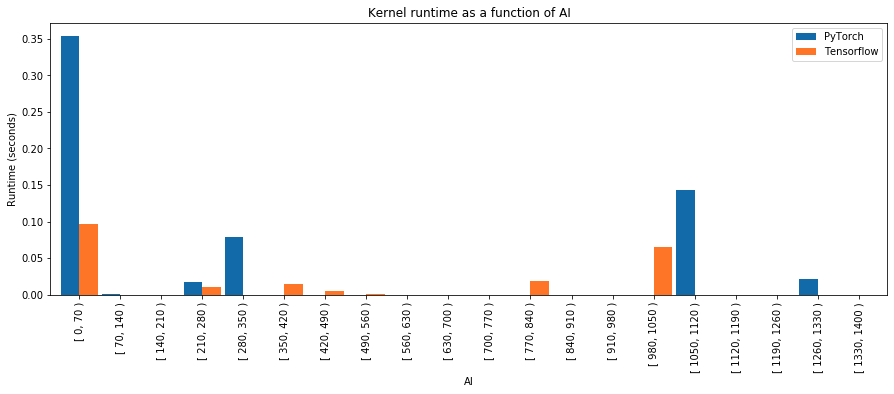

In [9]:
# AI range
ltfai = list(tfdf['DRAM AI'])
lptai = list(ptdf['DRAM AI'])
print('Tensorflow AI : {} - {:.5f}'.format(min(ltfai), max(ltfai)))
print('PyTorch AI    : {} - {:.5f}'.format(min(lptai), max(lptai)))

min_ai = 0.
max_ai = 1400.

# hist parameters
N = 20
stride = (max_ai - min_ai) / N

lhistid = []
lai     = []

for i in range(N):
    lhistid.append(i)
    airange = '[ ' + str(int(i * stride)) + ', ' + str(int((i+1) * stride)) + ' )'
    lai.append(airange)

resdf = pd.DataFrame({'Hist ID': lhistid, 'AI': lai})

def ai_classifier(row):
    res = '[ ' + str(int(row['DRAM AI'] / stride)*int(stride))\
          + ', ' + str(int(row['DRAM AI'] / stride + 1)*int(stride)) + ' )'
    return res

def hist_classifier(row):
    return int(row['DRAM AI'] / stride)
    
tfdf['AI'] = tfdf.apply(ai_classifier, axis=1)
ptdf['AI'] = ptdf.apply(ai_classifier, axis=1)
tfdf['Hist ID'] = tfdf.apply(hist_classifier, axis=1)
ptdf['Hist ID'] = ptdf.apply(hist_classifier, axis=1)

tmptf = tfdf.groupby(['Hist ID', 'AI']).sum().reset_index()
tmppt = ptdf.groupby(['Hist ID', 'AI']).sum().reset_index()

tmptf = tmptf.merge(tmppt, on=['Hist ID', 'AI'], how='outer')
resdf = resdf.merge(tmptf, on=['Hist ID', 'AI'], how='outer')
resdf = resdf[['Hist ID', 'AI', 'CUDA Time_x', 'CUDA Time_y']].fillna(0.).rename(columns={"CUDA Time_x": 'Tensorflow', 'CUDA Time_y': 'PyTorch'}).sort_values('Hist ID')
#display(resdf)

ax = resdf.plot.bar(x='AI', y=['PyTorch', 'Tensorflow'], figsize=(15, 5), title='Kernel runtime as a function of AI', width=0.9, color=mycolors)
ax = ax.set(ylabel='Runtime (seconds)')